## Set up

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import pandas as pd
import math
import seaborn as sns
import os
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import warnings
import lightning.pytorch as pl
import torch
import pickle
import xgboost as xgb
import optuna
import torch

from datetime import datetime, timedelta
from tqdm import tqdm
from lightning.pytorch import Trainer
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.data import TimeSeriesDataSet, GroupNormalizer
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import MAPE, QuantileLoss, RMSE, SMAPE
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.utilities.model_summary import summarize

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

np.random.seed(42)

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(math.log10(abs(num)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num_str = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  return f'{num_str}{letters[int(scale)]}'

def mpl_human_format(x, pos):
  """Formatter for matplotlib to use human_format."""
  if pos is not None:
    return human_format(x)
  return ''

def make_axes_human_readable(ax, axis="y"):
  """Apply human readable formatting to the specified axis of a matplotlib axes object."""
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise ValueError("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(ticker.FuncFormatter(mpl_human_format))
  return ax

## Import data

### Online retail

In [3]:
online_retail_df = pd.read_json('../../dataset/online_retail_data/online_retail.json')
online_retail_df

,Description,Date,UnitsSold,RevenuePounds,AveragePricePerUnitPounds
0,12 pencils small tube red spotty,2009-12-01,45,29.90,0.66
1,12 pencils small tube red spotty,2009-12-02,87,61.75,0.71
2,12 pencils small tube red spotty,2009-12-03,34,23.40,0.69
3,12 pencils small tube red spotty,2009-12-04,84,55.25,0.66
4,12 pencils small tube red spotty,2009-12-05,0,0.00,0.65
...,...,...,...,...,...
104933,wood black board ant white finish,2011-12-05,23,177.13,7.70
104934,wood black board ant white finish,2011-12-06,4,31.80,7.95
104935,wood black board ant white finish,2011-12-07,70,484.50,6.92
104936,wood black board ant white finish,2011-12-08,226,1142.34,5.05


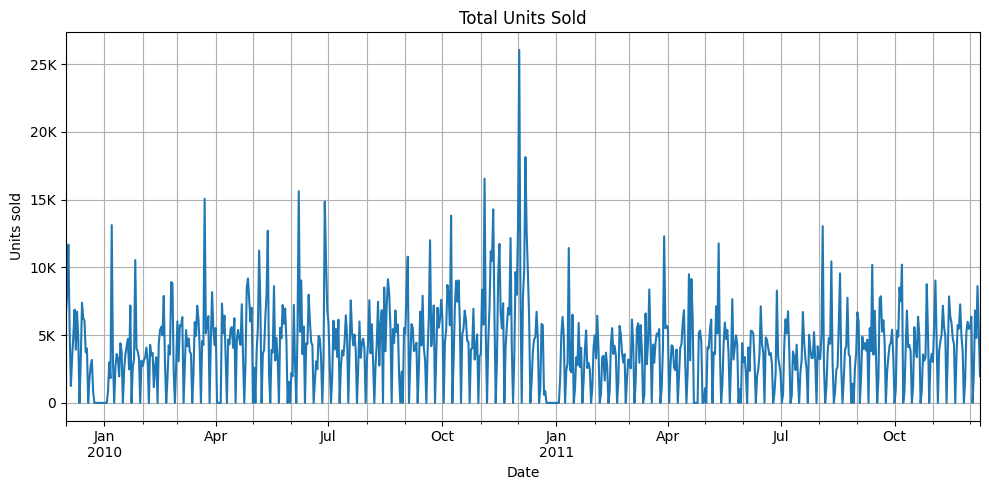

In [4]:
fig, ax = plt.subplots(figsize=(10,5))

online_retail_df.groupby('Date')['UnitsSold'].sum().plot(ax=ax)

ax.set_title('Total Units Sold')
ax.set_xlabel('Date')
ax.set_ylabel('Units sold')
ax.grid(True, which='both')
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

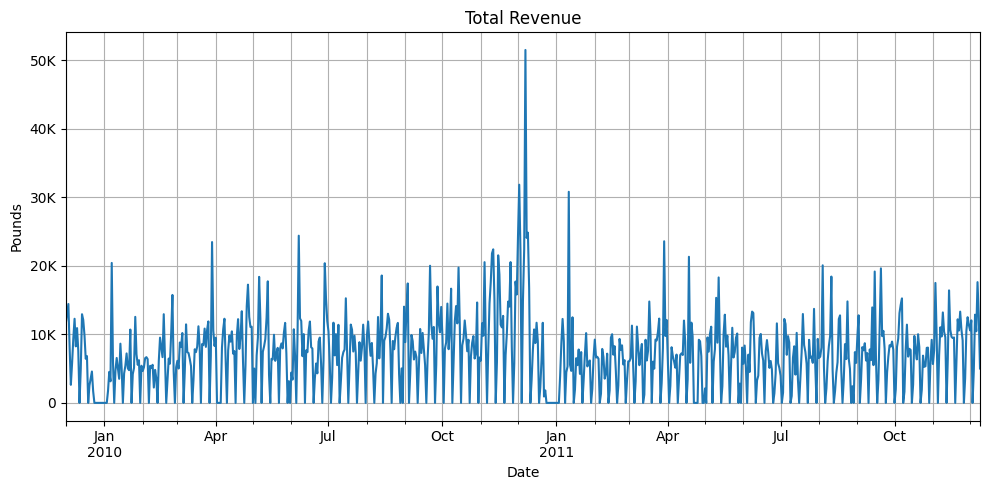

In [5]:
fig, ax = plt.subplots(figsize=(10,5))

online_retail_df.groupby('Date')['RevenuePounds'].sum().plot(ax=ax)

ax.set_title('Total Revenue')
ax.set_xlabel('Date')
ax.set_ylabel('Pounds')
ax.grid(True, which='both')
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

### Additional explanatory variables

In [6]:
COMMON_DIR = '../../dataset/explanatory_variables'

uk_daily_cci = (
    pd.read_json(os.path.join(COMMON_DIR, 'cci.json'), typ='series')
    .rename_axis('date')
    .sort_index()
)
uk_daily_cpi = (
    pd.read_json(os.path.join(COMMON_DIR, 'cpi.json'), typ='series')
    .rename_axis('date')
    .sort_index()
)
uk_daily_interest_rate = (
    pd.read_json(os.path.join(COMMON_DIR, 'interest_rate.json'), typ='series')
    .rename_axis('date')
    .sort_index()
)
uk_public_holidays = (
    pd.read_json(os.path.join(COMMON_DIR, 'public_holidays.json'), typ='series')
    .rename_axis('date')
    .sort_index()
)
uk_daily_unemployment = (
    pd.read_json(os.path.join(COMMON_DIR, 'unemployment.json'), typ='series')
    .rename_axis('date')
    .sort_index()
)

## Prepare the data

In [7]:
dates = online_retail_df['Date']
descriptions = online_retail_df['Description']
units_sold = online_retail_df['UnitsSold']
revenue = online_retail_df['RevenuePounds']
price = online_retail_df['AveragePricePerUnitPounds']

ordered_days = [
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday',
    'Sunday',
]
day_of_week = pd.Categorical(
    dates.dt.day_name(), categories=ordered_days, ordered=True
)

is_weekend = day_of_week.isin({'Saturday', 'Sunday'})

day_of_month = dates.dt.day
month = pd.Categorical(
    dates.dt.month_name(),
    categories=[
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ],
    ordered=True
)
quarter = pd.Categorical(
    'Q' + dates.dt.quarter.astype(str),
    categories=["Q1", "Q2", "Q3", "Q4"],
    ordered=True
)

day_before_units_sold = units_sold.shift(1).fillna(0)
day_before_log1p_units_sold = np.log1p(day_before_units_sold)

week_before_units_sold = units_sold.shift(7).fillna(0)
week_before_log1p_units_sold = np.log1p(week_before_units_sold)

rolling_3_mean_units_sold = units_sold.shift(1).rolling(3).mean().fillna(0)
rolling_3_mean_log1p_units_sold = np.log1p(rolling_3_mean_units_sold)

rolling_7_mean_units_sold = units_sold.shift(1).rolling(7).mean().fillna(0)
rolling_7_mean_log1p_units_sold = np.log1p(rolling_7_mean_units_sold)

log1p_units_sold = np.log1p(units_sold)

features_df = pd.DataFrame({
    'Date': dates,
    'Description': descriptions,
    'AvgPricePerUnitPounds': price.values,
    'DayBeforeUnitsSold': day_before_units_sold,
    'DayBeforeLog1pUnitsSold': day_before_log1p_units_sold.values,
    'WeekBeforeUnitsSold': week_before_units_sold,
    'WeekBeforeLog1pUnitsSold': week_before_log1p_units_sold.values,
    'Rolling3DayMeanUnitsSold': rolling_3_mean_units_sold,
    'Rolling3DayMeanLog1pUnitsSold': rolling_3_mean_log1p_units_sold.values,
    'Rolling7DayMeanUnitsSold': rolling_7_mean_units_sold,
    'Rolling7DayMeanLog1pUnitsSold': rolling_7_mean_log1p_units_sold.values,
    'UnitsSold': units_sold,
    'Log1pUnitsSold': log1p_units_sold.values,
    'IsWeekend': is_weekend,
    'DayOfWeek': day_of_week,
    'DayOfMonth': day_of_month.values,
    'Month': month,
    'Quarter': quarter,
})

features_df = features_df.merge(
    uk_daily_cci.rename('CCI'), left_on='Date', right_index=True, how='left'
)
features_df = features_df.merge(
    uk_daily_cpi.rename('CPI'), left_on='Date', right_index=True, how='left'
)
features_df = features_df.merge(
    uk_daily_interest_rate.rename('InterestRate'), left_on='Date', right_index=True, how='left'
)
features_df = features_df.merge(
    uk_daily_unemployment.rename('Unemployment'), left_on='Date', right_index=True, how='left'
)

uk_is_holiday = ~uk_public_holidays.resample('D').first().isna().fillna(False)

features_df = features_df.merge(
    uk_is_holiday.rename('IsHoliday'), left_on='Date', right_index=True, how='left'
)

features_df['IsHoliday'] = features_df['IsHoliday'].fillna(False)

features_df.insert(
    1,
    'TimeIdx',
    features_df
    .sort_values(['Description', 'Date'])  # ensure proper time order
    .groupby('Description')
    .cumcount() + 1
)

features_df

,Date,TimeIdx,Description,AvgPricePerUnitPounds,DayBeforeUnitsSold,DayBeforeLog1pUnitsSold,WeekBeforeUnitsSold,WeekBeforeLog1pUnitsSold,Rolling3DayMeanUnitsSold,Rolling3DayMeanLog1pUnitsSold,...,IsWeekend,DayOfWeek,DayOfMonth,Month,Quarter,CCI,CPI,InterestRate,Unemployment,IsHoliday
0,2009-12-01,1,12 pencils small tube red spotty,0.66,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,False,Tuesday,1,December,Q4,101.64,90.7,0.4517,7.7,False
1,2009-12-02,2,12 pencils small tube red spotty,0.71,45.0,3.828641,0.0,0.000000,0.000000,0.000000,...,False,Wednesday,2,December,Q4,101.64,90.7,0.4532,7.7,False
2,2009-12-03,3,12 pencils small tube red spotty,0.69,87.0,4.477337,0.0,0.000000,0.000000,0.000000,...,False,Thursday,3,December,Q4,101.64,90.7,0.4522,7.7,False
3,2009-12-04,4,12 pencils small tube red spotty,0.66,34.0,3.555348,0.0,0.000000,55.333333,4.031286,...,False,Friday,4,December,Q4,101.64,90.7,0.4502,7.7,False
4,2009-12-05,5,12 pencils small tube red spotty,0.65,84.0,4.442651,0.0,0.000000,68.333333,4.238926,...,True,Saturday,5,December,Q4,101.64,90.7,0.4502,7.7,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104933,2011-12-05,735,wood black board ant white finish,7.70,5.0,1.791759,2.0,1.098612,9.666667,2.367124,...,False,Monday,5,December,Q4,98.18,95.2,0.5273,8.3,False
104934,2011-12-06,736,wood black board ant white finish,7.95,23.0,3.178054,8.0,2.197225,9.333333,2.335375,...,False,Tuesday,6,December,Q4,98.18,95.2,0.5272,8.3,False
104935,2011-12-07,737,wood black board ant white finish,6.92,4.0,1.609438,29.0,3.401197,10.666667,2.456736,...,False,Wednesday,7,December,Q4,98.18,95.2,0.5264,8.3,False
104936,2011-12-08,738,wood black board ant white finish,5.05,70.0,4.262680,36.0,3.610918,32.333333,3.506558,...,False,Thursday,8,December,Q4,98.18,95.2,0.5392,8.3,False


## Sanity checks

In [8]:
# All TimeIdx start with 0
assert (features_df.groupby('Description')['TimeIdx'].min() != 1).sum() == 0

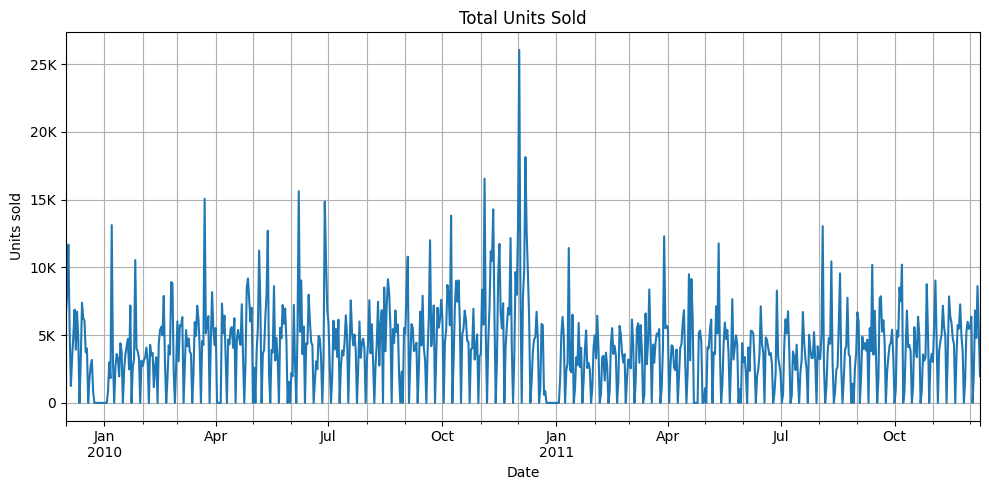

In [9]:
fig, ax = plt.subplots(figsize=(10,5))

features_df.groupby('Date')['UnitsSold'].sum().plot(ax=ax)

ax.set_title('Total Units Sold')
ax.set_xlabel('Date')
ax.set_ylabel('Units sold')
ax.grid(True, which='both')
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'log1p(UnitsSold)')

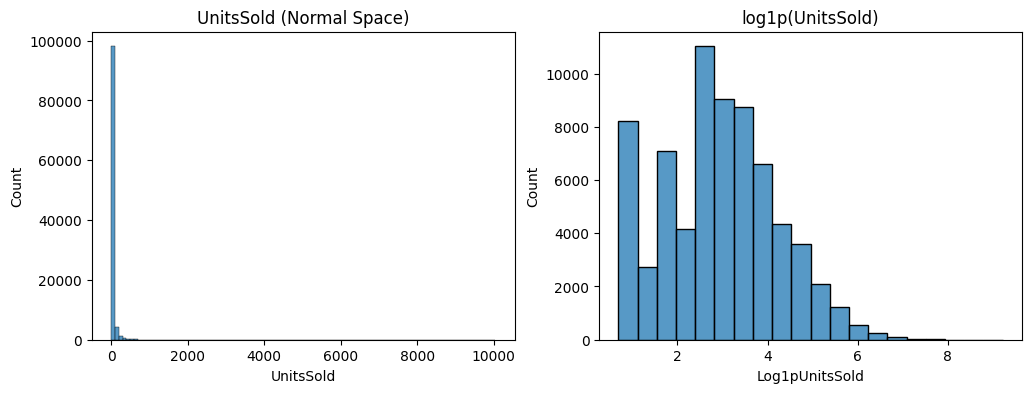

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(features_df["UnitsSold"], ax=ax[0], bins=100)
ax[0].set_title("UnitsSold (Normal Space)")
sns.histplot(features_df["Log1pUnitsSold"][features_df['UnitsSold'] > 0], ax=ax[1], bins=20)
ax[1].set_title("log1p(UnitsSold)")

## Save data

In [11]:
DIR_TO_SAVE_TO = '../../dataset/combined_retails_and_exog_data/'
FILENAME = 'combined_data.json'

os.makedirs(DIR_TO_SAVE_TO, exist_ok=True)

filepath = os.path.join(DIR_TO_SAVE_TO, FILENAME)

features_df.to_json(
    filepath,
    orient='records',
    date_format='iso',
    indent=4,
    index=False,
)